## Assignment 1


In [194]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pimpa.market_data_objects.curve import Curve
from pimpa.scenario_generation.brownian_motion import BrownianMotion
from pimpa.scenario_generation.geometric_brownian_motion import GeometricBrownianMotion
from pimpa.scenario_generation.hw1f import HW1F
from pimpa.utils.calendar_utils import generate_simulation_dates_schedule,transform_dates_to_time_differences
from pimpa.utils.notebook_tools import test_rfe_mean_and_vola, plot_rfe_paths, simulate_single_risk_factor
from pimpa.market_data_objects.market_data_builder import MarketDataBuilder
from data.configuration.global_parameters import global_parameters
from pimpa.data_objects.simulated_hw1f_curve import SimulatedHW1FCurve
from pimpa.market_data_objects.correlation_matrix import CorrelationMatrix
from pimpa.scenario_generation.multi_risk_factor_simulation import MultiRiskFactorSimulation
from pimpa.utils.notebook_tools import test_scenarios_marginal_distributions, test_scenarios_correlations

In [195]:
starting_date = '2020-01-01'
final_date = '2040-01-01'
valuation_frequency = 'monthly'
nr_paths = 10000  #global_parameters['n_paths']
simulation_dates = generate_simulation_dates_schedule(starting_date, final_date, valuation_frequency, global_parameters)
print('-----------------------------')
print(simulation_dates)
print('-----------------------------')

-----------------------------
[datetime.datetime(2020, 1, 1, 0, 0) datetime.datetime(2020, 2, 1, 0, 0)
 datetime.datetime(2020, 3, 1, 0, 0) datetime.datetime(2020, 4, 1, 0, 0)
 datetime.datetime(2020, 5, 1, 0, 0) datetime.datetime(2020, 6, 1, 0, 0)
 datetime.datetime(2020, 7, 1, 0, 0) datetime.datetime(2020, 8, 1, 0, 0)
 datetime.datetime(2020, 9, 1, 0, 0) datetime.datetime(2020, 10, 1, 0, 0)
 datetime.datetime(2020, 11, 1, 0, 0) datetime.datetime(2020, 12, 1, 0, 0)
 datetime.datetime(2021, 1, 1, 0, 0) datetime.datetime(2021, 2, 1, 0, 0)
 datetime.datetime(2021, 3, 1, 0, 0) datetime.datetime(2021, 4, 1, 0, 0)
 datetime.datetime(2021, 5, 1, 0, 0) datetime.datetime(2021, 6, 1, 0, 0)
 datetime.datetime(2021, 7, 1, 0, 0) datetime.datetime(2021, 8, 1, 0, 0)
 datetime.datetime(2021, 9, 1, 0, 0) datetime.datetime(2021, 10, 1, 0, 0)
 datetime.datetime(2021, 11, 1, 0, 0) datetime.datetime(2021, 12, 1, 0, 0)
 datetime.datetime(2022, 1, 1, 0, 0) datetime.datetime(2022, 2, 1, 0, 0)
 datetime.datet

-----------------------------
RF_HW1F_1 with 1 risk drivers
 1 Factor Hull White
 - alpha: 0.05
 - volatility: 0.01
-----------------------------
{'RFE_HW1F_calibration': {'RF_HW1F_1': {'rate_curve': <pimpa.market_data_objects.curve.Curve object at 0x7fcc408009a0>, 'alpha': 0.05, 'volatility': 0.01}}}
-----------------------------


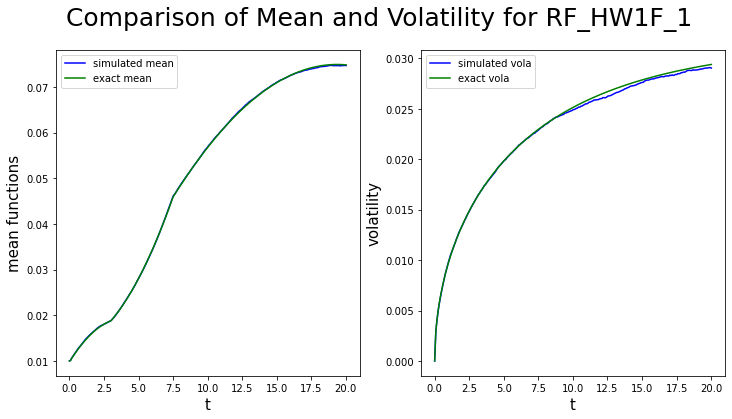

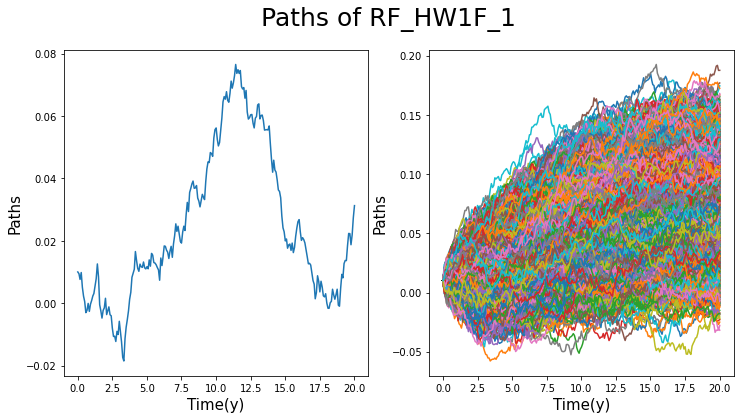

In [196]:
S_HW1F = HW1F('RF_HW1F_1') #choose a RF 

rate_curve = Curve({
    '1M': 0.01,
    '1Y': 0.012,
    '5Y': 0.018,
    '10Y': 0.03,
    '30Y': 0.05
}) 


#find dependencies 
#extract data 

market_data = {
    'RFE_HW1F_calibration': {
        'RF_HW1F_1': {
            'rate_curve': rate_curve,
            'alpha': 0.05,
            'volatility': 0.01
        }
    }
}
calibration_parameters = {'RFE_HW1F_calibration': {'RF_HW1F_1': {'calibration_method': 'direct_input'}}} 
S_HW1F.calibrate(market_data=market_data, calibration_parameters=calibration_parameters) #calibrate the model 
print('-----------------------------')
print(S_HW1F)
print('-----------------------------')
print(market_data)
print('-----------------------------')
paths = simulate_single_risk_factor(S_HW1F, simulation_dates, nr_paths) #run simulations with the model 
test_rfe_mean_and_vola(paths, simulation_dates, S_HW1F)
plot_rfe_paths(paths, simulation_dates, S_HW1F.name)

-----------------------------
EUR_ZERO_YIELD_CURVE with 1 risk drivers
 1 Factor Hull White
 - alpha: 0.04
 - volatility: 0.02
-----------------------------
{'RFE_HW1F_calibration': {'EUR_ZERO_YIELD_CURVE': {'alpha': 0.04, 'volatility': 0.02, 'rate_curve': <pimpa.market_data_objects.curve.Curve object at 0x7fcc59f3b0a0>}}}
-----------------------------


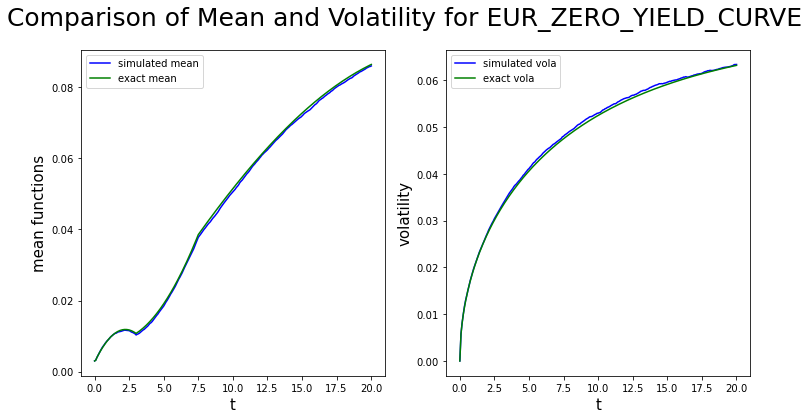

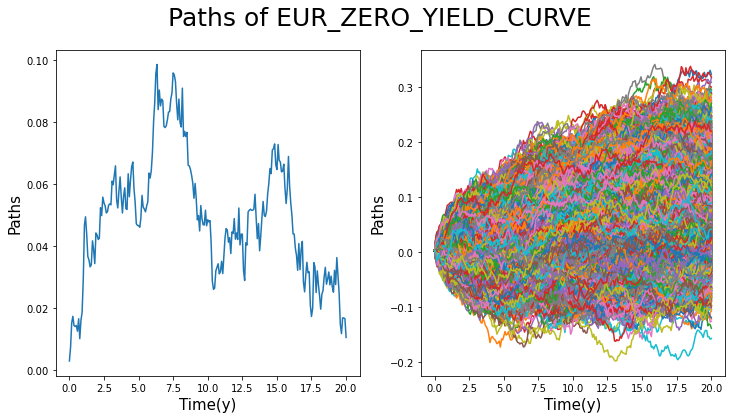

In [197]:
from data.configuration.global_parameters import calibration_parameters
S_HW1F = HW1F('EUR_ZERO_YIELD_CURVE')
RFE_dependencies=S_HW1F.get_dependencies(calibration_parameters)
market_data=MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
S_HW1F.calibrate(market_data=market_data, calibration_parameters=calibration_parameters)
print('-----------------------------')
print(S_HW1F)
print('-----------------------------')
print(market_data)
print('-----------------------------')
paths = simulate_single_risk_factor(S_HW1F, simulation_dates, nr_paths)
test_rfe_mean_and_vola(paths, simulation_dates, S_HW1F)
plot_rfe_paths(paths, simulation_dates, S_HW1F.name)

## Multifactor RF

In [198]:
from data.configuration.global_parameters import calibration_parameters
#Simulated RFs objects
simulated_risk_factors = set(['USD_ZERO_YIELD_CURVE','EUR_ZERO_YIELD_CURVE', 'EUR_USD_FX_RATE'])
print('-----------------------------')
simulated_risk_factor_objects = MarketDataBuilder().get_risk_factors(simulated_risk_factors, global_parameters)
print(simulated_risk_factor_objects)
print('-----------------------------')
#Construction of the RFs market data
RFE_dependencies=set()
for RF in simulated_risk_factors:
    model=simulated_risk_factor_objects[RF].model
    RFE_dependencies.update(model.get_dependencies(calibration_parameters))

market_data=MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
print(market_data) 
print('-----------------------------')
#Calibration of the RFs models 
_ = [rf.model.calibrate(market_data, calibration_parameters) for rf in simulated_risk_factor_objects.values()]
print(simulated_risk_factor_objects['USD_ZERO_YIELD_CURVE'].model)
print('-----------------------------')
print(simulated_risk_factor_objects['EUR_ZERO_YIELD_CURVE'].model)
print('-----------------------------')
print(simulated_risk_factor_objects['EUR_USD_FX_RATE'].model)
print('-----------------------------')
#Load the correlation matrix
correlation_matrix = CorrelationMatrix(file_path = global_parameters['prototype_data_paths']['RFE'] + \
                                       global_parameters['prototype_data_files']['RFE']['RFE_correlation_matrix'])
print(correlation_matrix.correlation_matrix)
print('-----------------------------')
scenario_object = MultiRiskFactorSimulation(simulated_risk_factor_objects.values(), correlation_matrix)
simulated_scenarios=scenario_object.generate_scenarios(simulation_dates, global_parameters)

-----------------------------
{'EUR_ZERO_YIELD_CURVE': RiskFactor(name='EUR_ZERO_YIELD_CURVE', asset_class='IR', asset_type='DISCOUNT_CURVE', currency='EUR', simulated=True, model=<pimpa.scenario_generation.hw1f.HW1F object at 0x7fcc64f5a310>, model_name='HW1F', reference=None), 'USD_ZERO_YIELD_CURVE': RiskFactor(name='USD_ZERO_YIELD_CURVE', asset_class='IR', asset_type='DISCOUNT_CURVE', currency='USD', simulated=True, model=<pimpa.scenario_generation.hw1f.HW1F object at 0x7fcc64f5a3d0>, model_name='HW1F', reference=None), 'EUR_USD_FX_RATE': RiskFactor(name='EUR_USD_FX_RATE', asset_class='FX', asset_type='SPOT', currency='EUR', simulated=True, model=<pimpa.scenario_generation.geometric_brownian_motion.GeometricBrownianMotion object at 0x7fcc64f5a580>, model_name='GBM', reference=None)}
-----------------------------
{'RFE_GBM_calibration': {'EUR_USD_FX_RATE': {'initial_value': 1.2, 'drift': 0.0, 'volatility': 0.1}}, 'RFE_HW1F_calibration': {'EUR_ZERO_YIELD_CURVE': {'alpha': 0.04, 'volat

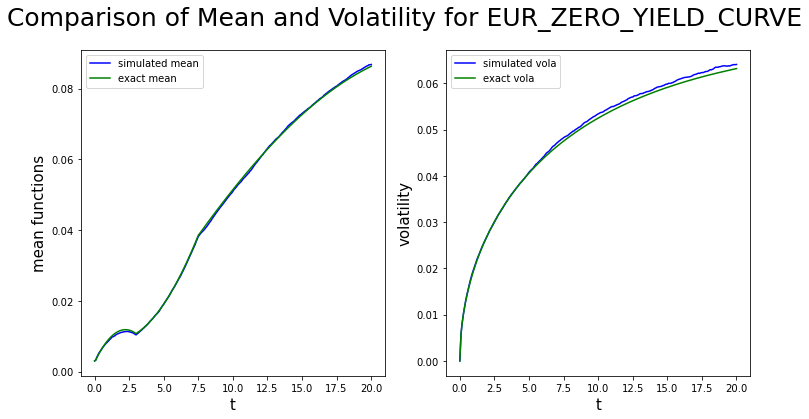

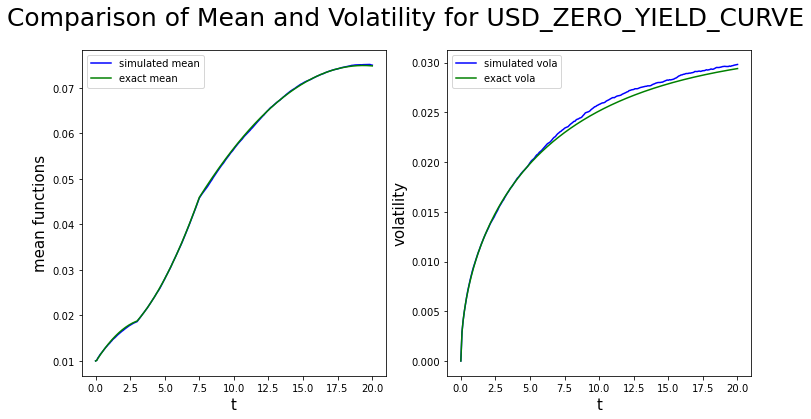

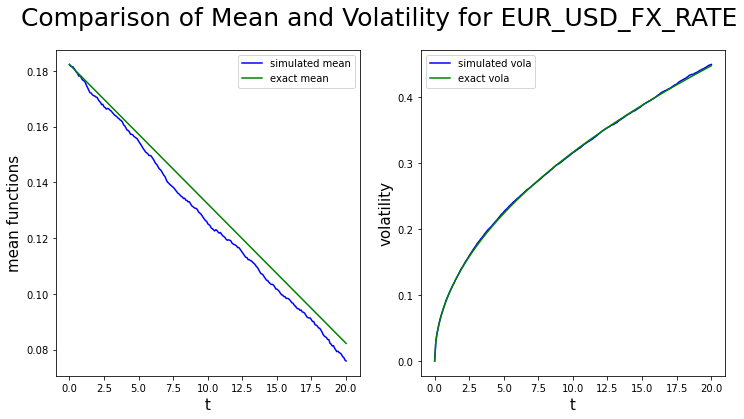

-----------------------------
The max observed error in correlations is 0.0005278820029536169
-----------------------------
                                             realised_correlations  \
EUR_ZERO_YIELD_CURVE_X_EUR_ZERO_YIELD_CURVE               1.000000   
EUR_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE               0.899472   
USD_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE               1.000000   
EUR_USD_FX_RATE_X_EUR_ZERO_YIELD_CURVE                    0.199578   
EUR_USD_FX_RATE_X_USD_ZERO_YIELD_CURVE                    0.099647   
EUR_USD_FX_RATE_X_EUR_USD_FX_RATE                         1.000000   

                                             true_correlations  
EUR_ZERO_YIELD_CURVE_X_EUR_ZERO_YIELD_CURVE                1.0  
EUR_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE                0.9  
USD_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE                1.0  
EUR_USD_FX_RATE_X_EUR_ZERO_YIELD_CURVE                     0.2  
EUR_USD_FX_RATE_X_USD_ZERO_YIELD_CURVE                     0

In [199]:
test_scenarios_marginal_distributions(simulated_scenarios, scenario_object)
correlations, max_error = test_scenarios_correlations(simulated_scenarios, scenario_object, correlation_matrix)
print('-----------------------------')
print(f'The max observed error in correlations is {max_error}')
print('-----------------------------')
print(correlations)
print('-----------------------------')

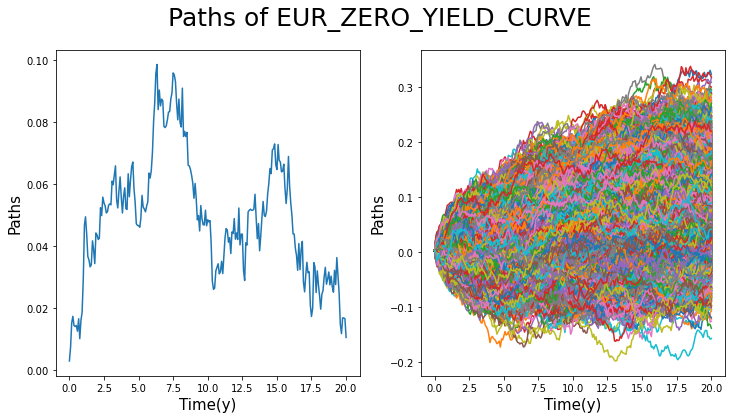

In [200]:
plot_rfe_paths(paths, simulation_dates, S_HW1F.name)

## Assignment 2

In [216]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from pimpa.trade_models.portfolio import Portfolio
from pimpa.evaluators.ccr_valuation_session import CCR_Valuation_Session
from data.configuration.global_parameters import global_parameters
from pimpa.utils.calendar_utils import transform_dates_to_time_differences

from pimpa.pricing_models.interest_rate_swap_pricer import InterestRateSwapPricer
from pimpa.pricing_models.equity_european_option_pricer import EquityEuropeanOptionPricer
from pimpa.trade_models.interest_rate_swap import InterestRateSwap
from pimpa.trade_models.equity_european_option import EquityEuropeanOption
from pimpa.market_data_objects.market_data_builder import MarketDataBuilder
from pimpa.utils.calendar_utils import generate_simulation_dates_schedule

from data.configuration.global_parameters import global_parameters, calibration_parameters

In [217]:
trade_id = 3234
risk_factors = pd.read_csv(global_parameters['prototype_data_paths']['RFs_attributes'] + global_parameters['prototype_data_files']['RFs_attributes']['all_RFs_mapping'])
trade = InterestRateSwap(trade_id)
trade.load(global_parameters, risk_factors)
print('-----------------------------')
print(trade)
print('-----------------------------')

-----------------------------
Trade with trade_id: 3234
- trade type: IRS
- asset class: IR
- trade currency: EUR
- trade underlyings: ['EUR_LIBOR_3M_CURVE', 'EUR_ZERO_YIELD_CURVE']
- trade attributes keys: ['notional', 'currency', 'floating_rate', 'K', 'payer/receiver', 'first_fixing_date', 'last_fixing_date', 'first_payment_date', 'last_payment_date', 'payments_frequency', 'maturity', 'fixings_schedule', 'payments_schedule'])
- with 41 valuation points.
AVAILABLE
-----------------------------


In [218]:
pricer = InterestRateSwapPricer('IRS_Pricer')
risk_factor_objects = MarketDataBuilder().get_risk_factors(trade.trade_underlyings, global_parameters)
print('-----------------------------')
print(risk_factor_objects)
print('-----------------------------')
pricer_dependencies = pricer.get_market_dependencies(trade.trade_underlyings, risk_factor_objects,calibration_parameters)
print(pricer_dependencies)
print('-----------------------------')

-----------------------------
{'EUR_ZERO_YIELD_CURVE': RiskFactor(name='EUR_ZERO_YIELD_CURVE', asset_class='IR', asset_type='DISCOUNT_CURVE', currency='EUR', simulated=True, model=<pimpa.scenario_generation.hw1f.HW1F object at 0x7fcc7311d6a0>, model_name='HW1F', reference=None), 'EUR_LIBOR_3M_CURVE': RiskFactor(name='EUR_LIBOR_3M_CURVE', asset_class='IR', asset_type='SPREAD_TO_DISCOUNT_CURVE', currency='EUR', simulated=False, model=None, model_name='NOT_AVAILABLE', reference='EUR_ZERO_YIELD_CURVE')}
-----------------------------
{('historical_fixings', 'EUR_LIBOR_3M_CURVE'), ('Pricing_HW1F_calibration', 'EUR_ZERO_YIELD_CURVE'), ('historical_fixings', 'EUR_ZERO_YIELD_CURVE'), ('spread_to_discount_curve', 'EUR_LIBOR_3M_CURVE')}
-----------------------------


In [219]:
market_data = MarketDataBuilder().load_market_data(pricer_dependencies, global_parameters)
print('-----------------------------')
print(market_data)
print('-----------------------------')
pricer.calibrate(market_data, calibration_parameters)
print(pricer)
print('-----------------------------')

-----------------------------
{'historical_fixings': {'EUR_LIBOR_3M_CURVE': 2020-01-01    0.001
2019-12-31    0.001
2019-12-30    0.001
2019-12-29    0.001
2019-12-28    0.001
              ...  
2018-12-18    0.001
2018-12-17    0.001
2018-12-16    0.001
2018-12-15    0.001
2018-12-14    0.001
Name: EUR_LIBOR_3M_CURVE, Length: 384, dtype: float64, 'EUR_ZERO_YIELD_CURVE': 2020-01-01    0.005
2019-12-31    0.010
2019-12-30    0.010
2019-12-29    0.010
2019-12-28    0.010
              ...  
2018-12-18    0.010
2018-12-17    0.010
2018-12-16    0.010
2018-12-15    0.010
2018-12-14    0.010
Name: EUR_ZERO_YIELD_CURVE, Length: 384, dtype: float64}, 'Pricing_HW1F_calibration': {'EUR_ZERO_YIELD_CURVE': {'alpha': 0.04, 'volatility': 0.02, 'rate_curve': <pimpa.market_data_objects.curve.Curve object at 0x7fcc12ca5c10>}}, 'spread_to_discount_curve': {'EUR_LIBOR_3M_CURVE': <pimpa.market_data_objects.curve.Curve object at 0x7fcc5bc75880>}}
-----------------------------
----------------------------

[[-43.08301741 -24.91355001 -79.27453734 ...   0.           0.
    0.        ]
 [-43.08301741 -50.03095377 -35.32745425 ...   0.           0.
    0.        ]
 [-43.08301741 -28.04708857 -61.18051806 ...   0.           0.
    0.        ]
 ...
 [-43.08301741 -47.83425551 -76.86892806 ...   0.           0.
    0.        ]
 [-43.08301741 -50.94166643 -58.9773906  ...   0.           0.
    0.        ]
 [-43.08301741 -51.96508117 -36.41188004 ...   0.           0.
    0.        ]]
[-43.08301741 -51.96508117 -36.41188004 -66.5926827  -53.94538741
 -24.46930661 -20.54632618 -21.05430152 -24.69034904 -12.6083059
 -13.93647016  27.34901773  51.48100629  52.82437106  56.73510933
  85.43864946  82.17945703 123.56812775  86.8821489   90.73423709
 103.65896043 119.56960342 143.47669632 134.95051389 155.1767139
 142.84566777 152.06185385 134.5379861  120.02695255 137.97929256
 144.67200942 149.46152627 159.06945991 160.29027315 154.79709589
 151.43955956 153.39116031 157.15801055 151.8381363  161.101

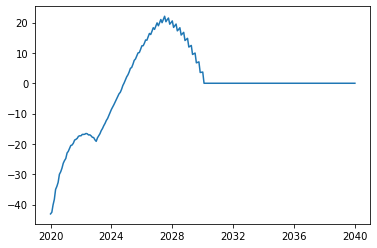

In [223]:
starting_date = '2020-01-01'
final_date = '2040-01-01'
valuation_frequency = 'monthly'
nr_paths = 10000
global_parameters['n_paths'] = nr_paths
#valuation_dates = generate_simulation_dates_schedule(starting_date, final_date, valuation_frequency, global_parameters)

trade_mtms = pricer.price_single_trade(trade, simulation_dates, simulated_scenarios, market_data, global_parameters)

trade_mtms_avg = trade_mtms.mean(axis=0)

print(trade_mtms)
print(trade_mtms[-1][:])

plt.plot(simulation_dates, trade_mtms_avg)

## Assignment 3

We create a new portfolio by adding two new trades in desks/IRS for a new counterparty 27, then also adding these to the master ledger. Then we create a Portfolio object and a CCR_Valuation_Session and run it with pe_quantile 95% and MPOR = 4w = 28 days.

In [206]:

netting_agreement_id = 27

#Create portfolio object
portfolio_1 = Portfolio(netting_agreement_id)
portfolio_1.load(global_parameters)
print('-----------------------------')
print('Portfolio underlyings:')
for rf in portfolio_1.portfolio_underlyings:
    print(rf)
print('-----------------------------')
print('Portfolio trades:')
for _, trade in portfolio_1.trade_inventory.items():
    print(trade)
portfolio_1_run = CCR_Valuation_Session(portfolio_1)
today_date = '2019-10-10'
portfolio_1_run.run(today_date, global_parameters, pe_quantiles=[0.95], mpor_d=28)
print('-----------------------------')
print('Market dependencies:')
print(portfolio_1_run.market_dependencies)
print('-----------------------------')
print('Risk factors:')
for rf in portfolio_1_run.risk_factors.values():
    print(rf)
print('-----------------------------')
print('Portfolio netting sets:')
print(portfolio_1.netting_sets)
print('-----------------------------')
print('VM_collateral_agreements:')
print(portfolio_1.vm_collateral_agreements)
print('-----------------------------')
print('valuation as of: '+today_date)
portfolio_1_exposures = portfolio_1_run.get_exposures()
print('-----------------------------')
print(portfolio_1_exposures)
print('-----------------------------')

-----------------------------
Portfolio underlyings:
EUR_ZERO_YIELD_CURVE
EUR_USD_FX_RATE
USD_LIBOR_3M_CURVE
USD_ZERO_YIELD_CURVE
EUR_LIBOR_3M_CURVE
-----------------------------
Portfolio trades:
Trade with trade_id: 3234
- trade type: IRS
- asset class: IR
- trade currency: EUR
- trade underlyings: ['EUR_LIBOR_3M_CURVE', 'EUR_ZERO_YIELD_CURVE']
- trade attributes keys: ['notional', 'currency', 'floating_rate', 'K', 'payer/receiver', 'first_fixing_date', 'last_fixing_date', 'first_payment_date', 'last_payment_date', 'payments_frequency', 'maturity', 'fixings_schedule', 'payments_schedule'])
- with 41 valuation points.
AVAILABLE
Trade with trade_id: 3235
- trade type: IRS
- asset class: IR
- trade currency: USD
- trade underlyings: ['USD_LIBOR_3M_CURVE', 'USD_ZERO_YIELD_CURVE']
- trade attributes keys: ['notional', 'currency', 'floating_rate', 'K', 'payer/receiver', 'first_fixing_date', 'last_fixing_date', 'first_payment_date', 'last_payment_date', 'payments_frequency', 'maturity', 'fi

Plotting all the results. For all Exposures, we can see that it is low initally as their is not as much uncertainty. When time passes more uncertainty is introduced and the exposure increases. As we go towards end of maturity, uncertainty is high but there aren't as many cashflows left to be affected by this uncertainty, this leads to the bell curve shape of the Exposures. Comparing Expected and Potential Exposures, we see that they follow similar patterns but the exposures are bigger in the Potential Exposures. Comparing Collat

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.45894767e-03
  8.26300764e-02 4.28549295e+00 8.60790682e+00 1.23463457e+01
  1.19638085e+01 1.38652806e+00 0.00000000e+00 0.00000000e+00]]
[datetime.datetime(2019, 10, 10, 0, 0), datetime.datetime(2019, 10, 11, 0, 0), datetime.datetime(2019, 10, 17, 0, 0), datetime.datetime(2019, 10, 24, 0, 0), datetime.datetime(2019, 11, 10, 0, 0), datetime.datetime(2020, 4, 10, 0, 0), datetime.datetime(2020, 10, 10, 0, 0), datetime.datetime(2021, 10, 10, 0, 0), datetime.datetime(2024, 10, 10, 0, 0), datetime.datetime(2029, 10, 10, 0, 0), datetime.datetime(2039, 10, 10, 0, 0), datetime.datetime(2069, 10, 10, 0, 0)]


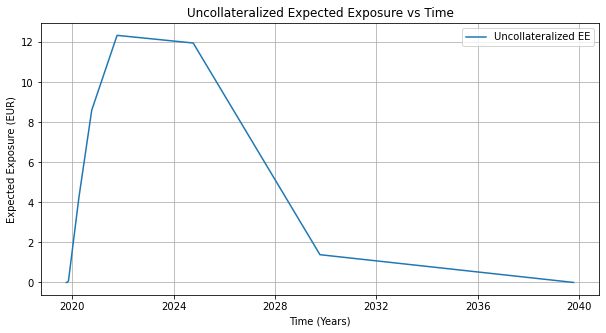

In [207]:
print(portfolio_1_run.uncollateralised_ee)
print(portfolio_1_run.b3_default_grid)


plt.figure(figsize=(10, 5))
plt.plot(
    portfolio_1_run.b3_default_grid[:-1],
    portfolio_1_run.uncollateralised_ee[0][:-1],
    label='Uncollateralized EE'
)
plt.xlabel('Time (Years)')
plt.ylabel('Expected Exposure (EUR)')
plt.title('Uncollateralized Expected Exposure vs Time')
plt.grid(True)
plt.legend()
plt.show()



{0.95: array([[-30.39720668, -25.91832117, -18.61634053, -13.86251187,
         -6.32011849,  28.06387986,  46.71345666,  61.00250744,
         60.13963159,   6.21742947,   0.        ,   0.        ]])}
[datetime.datetime(2019, 10, 10, 0, 0), datetime.datetime(2019, 10, 11, 0, 0), datetime.datetime(2019, 10, 17, 0, 0), datetime.datetime(2019, 10, 24, 0, 0), datetime.datetime(2019, 11, 10, 0, 0), datetime.datetime(2020, 4, 10, 0, 0), datetime.datetime(2020, 10, 10, 0, 0), datetime.datetime(2021, 10, 10, 0, 0), datetime.datetime(2024, 10, 10, 0, 0), datetime.datetime(2029, 10, 10, 0, 0), datetime.datetime(2039, 10, 10, 0, 0), datetime.datetime(2069, 10, 10, 0, 0)]


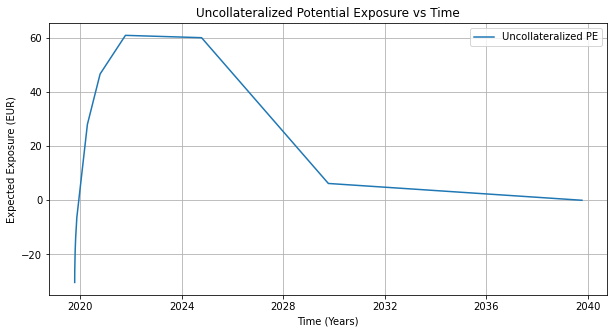

In [208]:
print(portfolio_1_run.uncollateralised_pe)
print(portfolio_1_run.b3_default_grid)


plt.figure(figsize=(10, 5))
plt.plot(
    portfolio_1_run.b3_default_grid[:-1],
    portfolio_1_run.uncollateralised_pe[0.95][0][:-1],
    label='Uncollateralized PE'
)
plt.xlabel('Time (Years)')
plt.ylabel('Expected Exposure (EUR)')
plt.title('Uncollateralized Potential Exposure vs Time')
plt.grid(True)
plt.legend()
plt.show()

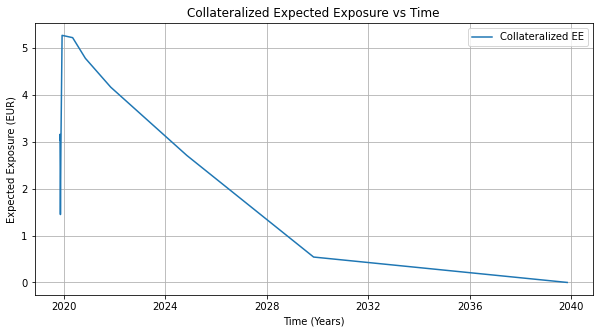

In [209]:
plt.figure(figsize=(10, 5))
plt.plot(
    portfolio_1_run.b3_closeout_grid[:-1],
    portfolio_1_run.collateralised_ee[0][:-1],
    label='Collateralized EE'
)
plt.xlabel('Time (Years)')
plt.ylabel('Expected Exposure (EUR)')
plt.title('Collateralized Expected Exposure vs Time')
plt.grid(True)
plt.legend()
plt.show()


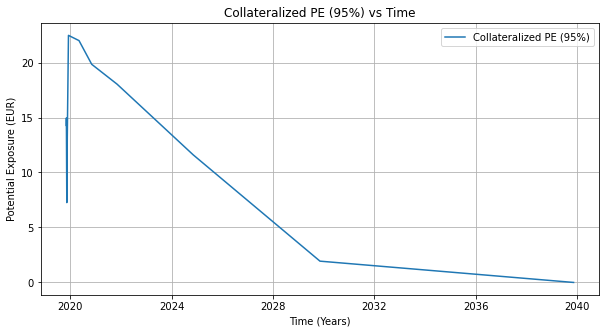

In [210]:
plt.figure(figsize=(10, 5))
plt.plot(
    portfolio_1_run.b3_closeout_grid[:-1],
    portfolio_1_run.collateralised_pe[0.95][0][:-1],
    label='Collateralized PE (95%)'
)
plt.xlabel('Time (Years)')
plt.ylabel('Potential Exposure (EUR)')
plt.title('Collateralized PE (95%) vs Time')
plt.grid(True)
plt.legend()
plt.show()


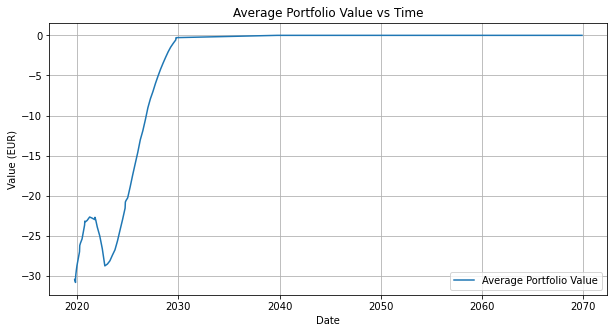

[-30.39720668 -30.37994883 -30.4231019  -30.56376261 -30.75114969
 -30.78362173 -30.40134133 -30.06381005 -29.78081413 -29.27729597
 -28.66609582 -26.96622967 -26.17276689 -25.85618547 -25.37346241
 -23.63551667 -23.14209478 -23.21099152 -23.05920019 -22.63023669
 -22.77361644 -22.95247062 -22.67155141 -22.99530891 -23.87542714
 -24.98712488 -26.57410197 -28.72073383 -28.49411484 -28.09373245
 -27.38763766 -26.72418111 -25.59994719 -24.25980824 -22.95550662
 -21.52246271 -20.7639051  -20.55069894 -20.25195555 -18.88640838
 -17.3936927  -15.97572404 -14.5735489  -13.01781768 -11.89972547
 -10.51743392  -9.0117878   -7.90027291  -7.00529549  -5.98332103
  -5.06933588  -4.22080603  -3.45915915  -2.73565429  -2.04543254
  -1.46734477  -1.00072226  -0.56886835  -0.29814104  -0.28233415
   0.           0.           0.           0.        ]
[datetime.datetime(2020, 1, 1, 0, 0) datetime.datetime(2020, 2, 1, 0, 0)
 datetime.datetime(2020, 3, 1, 0, 0) datetime.datetime(2020, 4, 1, 0, 0)
 datetim

In [211]:
avg_portfolio_value = portfolio_1_run.scenarios_portfolio_values.mean(axis=0)
plt.figure(figsize=(10, 5))
plt.plot(
    portfolio_1_run.simulation_dates,
    avg_portfolio_value,
    label='Average Portfolio Value'
)
plt.xlabel('Date')
plt.ylabel('Value (EUR)')
plt.title('Average Portfolio Value vs Time')
plt.grid(True)
plt.legend()
plt.show()

print(avg_portfolio_value)
print(simulation_dates)

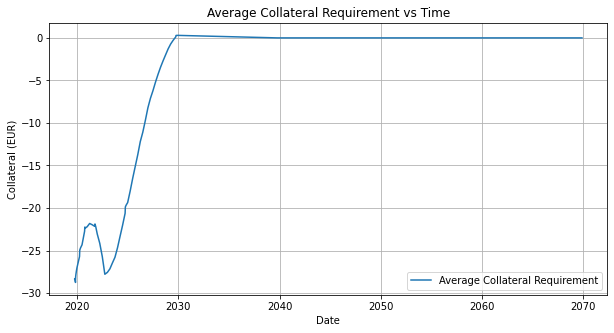

In [212]:
avg_collateral = portfolio_1_run.scenarios_collateral_requirements.mean(axis=0)

plt.figure(figsize=(10, 5))
plt.plot(
    portfolio_1_run.simulation_dates,
    avg_collateral,
    label='Average Collateral Requirement'
)
plt.xlabel('Date')
plt.ylabel('Collateral (EUR)')
plt.title('Average Collateral Requirement vs Time')
plt.grid(True)
plt.legend()
plt.show()


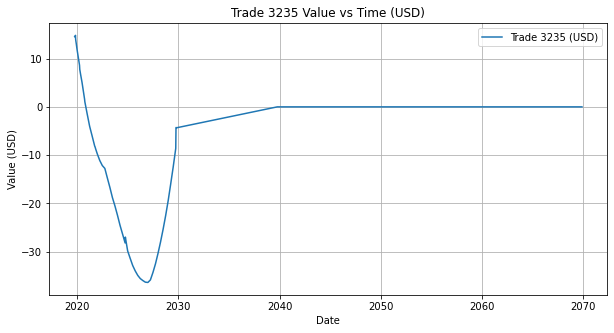

In [213]:
avg_3235_usd = portfolio_1_run.scenarios_MtMs[3235].mean(axis=0)

plt.figure(figsize=(10, 5))
plt.plot(
    portfolio_1_run.simulation_dates,
    avg_3235_usd,
    label='Trade 3235 (USD)'
)
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.title('Trade 3235 Value vs Time (USD)')
plt.grid(True)
plt.legend()
plt.show()


[[1.2        1.19861296 1.17301028 ... 1.65914451 1.19814318 1.19901219]
 [1.2        1.19631768 1.18067145 ... 0.63030195 0.63623686 0.62475231]
 [1.2        1.2078733  1.20145419 ... 2.78867966 2.71167647 2.84503822]
 ...
 [1.2        1.20265483 1.21561899 ... 1.12335575 0.65428091 0.63501995]
 [1.2        1.1914819  1.20248504 ... 0.85446351 0.48239957 0.4978263 ]
 [1.2        1.20548993 1.17220178 ... 0.97584868 0.77694112 0.75682097]]


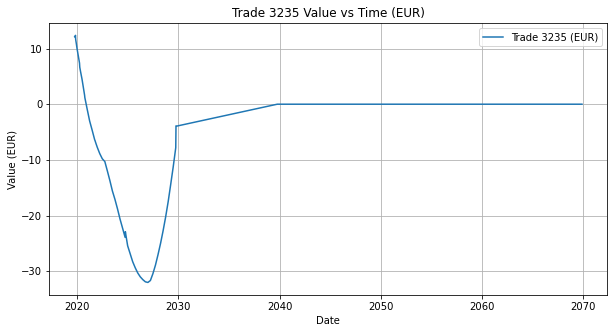

In [214]:
# Convert to EUR if needed
fx_usdeur = portfolio_1_run.scenarios['EUR_USD_FX_RATE']
print(fx_usdeur)
avg_3235_eur = (portfolio_1_run.scenarios_MtMs[3235] / fx_usdeur).mean(axis=0)

plt.figure(figsize=(10, 5))
plt.plot(
    portfolio_1_run.simulation_dates,
    avg_3235_eur,
    label='Trade 3235 (EUR)'
)
plt.xlabel('Date')
plt.ylabel('Value (EUR)')
plt.title('Trade 3235 Value vs Time (EUR)')
plt.grid(True)
plt.legend()
plt.show()
